# Is our knockoff similar to Mateo's knockoffs?

SNPknock documentation: https://cran.r-project.org/web/packages/SNPknock/SNPknock.pdf

In [1]:
using Revise
using LinearAlgebra
using DelimitedFiles
using Distributions
using ProgressMeter
using SnpArrays
using Random
using Knockoffs
using BenchmarkTools
using Plots
using fastPHASE
using RCall
using CSV, DataFrames

plinkname = "/Users/biona001/.julia/dev/Knockoffs/fastphase/1k/ukb.10k.chr10"
datadir = "/Users/biona001/.julia/dev/Knockoffs/fastphase/1k"
# plinkname = "ukb.10k.chr10"
# datadir = "/scratch/users/bbchu/fastphase/1k_K10"
T = 10
extension="ukb_chr10_n1000"
gr(fmt=:png)

┌ Info: Precompiling Knockoffs [878bf26d-0c49-448a-9df5-b057c815d613]
└ @ Base loading.jl:1317


Plots.GRBackend()

# Julia knockoff statistics

In [38]:
X̃ = hmm_knockoff(plinkname, "../fastphase/1k/tmp1", outdir="../fastphase/1k/", 
    plink_outfile="ukb.1k.chr10.knockoff.new")

Progress: 100%|█████████████████████████████████████████| Time: 0:47:38


10000×29481 SnpArray:
 0x02  0x02  0x02  0x00  0x02  0x00  …  0x00  0x00  0x00  0x00  0x00  0x00
 0x00  0x00  0x03  0x00  0x03  0x00     0x00  0x00  0x00  0x00  0x02  0x00
 0x00  0x03  0x03  0x03  0x00  0x00     0x00  0x00  0x00  0x00  0x00  0x00
 0x00  0x00  0x00  0x00  0x00  0x00     0x00  0x00  0x00  0x02  0x02  0x00
 0x00  0x02  0x03  0x02  0x02  0x00     0x00  0x00  0x02  0x00  0x02  0x02
 0x00  0x00  0x03  0x00  0x02  0x00  …  0x00  0x00  0x00  0x00  0x00  0x00
 0x00  0x00  0x03  0x00  0x00  0x00     0x00  0x00  0x00  0x00  0x02  0x00
 0x00  0x00  0x03  0x00  0x03  0x00     0x00  0x00  0x00  0x02  0x02  0x00
 0x00  0x00  0x03  0x00  0x02  0x00     0x00  0x00  0x00  0x00  0x02  0x00
 0x00  0x00  0x03  0x00  0x03  0x00     0x00  0x00  0x00  0x00  0x00  0x00
 0x00  0x02  0x03  0x02  0x00  0x00  …  0x00  0x00  0x00  0x00  0x00  0x00
 0x00  0x00  0x03  0x00  0x02  0x02     0x00  0x00  0x00  0x00  0x00  0x00
 0x00  0x00  0x03  0x00  0x02  0x00     0x00  0x00  0x00  0x00  0x02  0x02
   

In [2]:
X = SnpArray(joinpath(datadir, "ukb.10k.chr10.bed"))
X̃ = SnpArray(joinpath(datadir, "ukb.1k.chr10.knockoff.new.bed"));

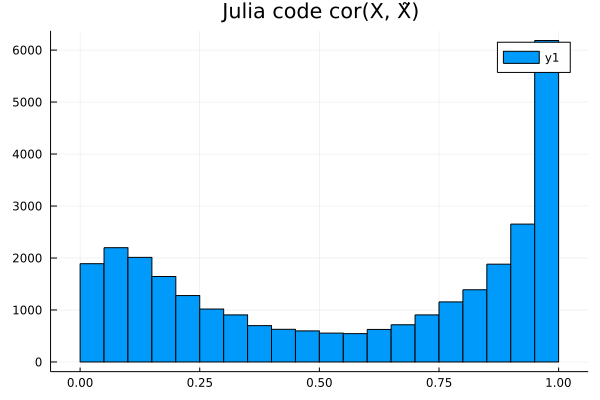

In [3]:
# correlation between X and X̃
n, p = size(X)
r2, snp1, snp2 = sizehint!(Float64[], p), zeros(n), zeros(n)
for i in 1:p
    copyto!(snp1, @view(X̃[:, i]), center=true, scale=true)
    copyto!(snp2, @view(X[:, i]), center=true, scale=true)
    push!(r2, abs(cor(snp1, snp2)))
end
histogram(r2, title="Julia code cor(X, X̃)")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


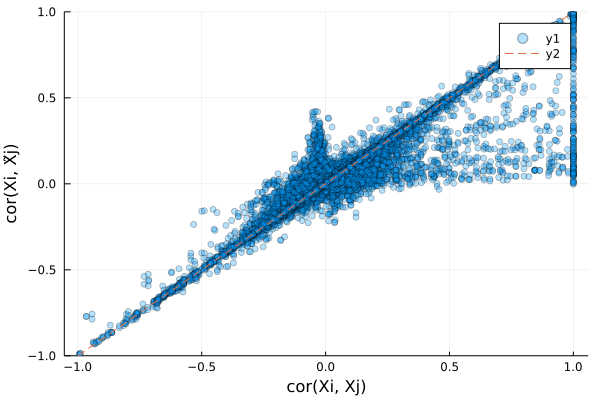

In [5]:
# compare cor(X[i], X[j]) and cor(X[i], X̃[j])
n, p = size(X)
r1, r2, snp1, snp2 = Float64[], Float64[], zeros(n), zeros(n)
@showprogress for i in 1:200, j in 1:200
    copyto!(snp1, @view(X[:, i]))
    copyto!(snp2, @view(X[:, j]))
    push!(r1, cor(snp1, snp2))
    copyto!(snp2, @view(X̃[:, j]))
    push!(r2, cor(snp1, snp2))
end
julia_plt = scatter(r1, r2, alpha=0.3, ylim=(-1, 1), xlabel = "cor(Xi, Xj)", ylabel="cor(Xi, X̃j)")
Plots.abline!(1, 0, line=:dash)


# Generate Mateo's knockoffs

First send Julia variables over to R

In [4]:
n, p = size(X)
Xint = Int.(convert(Matrix{Float32}, X))
@rput Xint n p

29481

Run Mateo's package

In [5]:
@time begin
    R"""
    library("SNPknock")

    # fastPHASE output files
    r_file = "/Users/biona001/.julia/dev/Knockoffs/fastphase/1k/tmp1_rhat.txt"
    alpha_file = "/Users/biona001/.julia/dev/Knockoffs/fastphase/1k/tmp1_alphahat.txt"
    theta_file = "/Users/biona001/.julia/dev/Knockoffs/fastphase/1k/tmp1_thetahat.txt"
    char_file = "/Users/biona001/.julia/dev/Knockoffs/fastphase/1k/tmp1_origchars"

    # load HMM
    hmm = loadHMM(r_file, alpha_file, theta_file, char_file)
    hmm$r = hmm$r[1:p]
    hmm$alpha = hmm$alpha[1:p,]
    hmm$theta = hmm$theta[1:p,]

    # Generate knockoffs
    X_ko = knockoffGenotypes(Xint, hmm$r, hmm$alpha, hmm$theta)
    """
end

1353.158404 seconds (12.63 k allocations: 838.626 KiB, 0.00% compilation time)


RObject{IntSxp}
         [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10] [,11] [,12] [,13]
    [1,]    1    0    1    0    1    0    0    0    0     0     0     1     0
    [2,]    0    0    2    0    1    0    0    0    0     0     0     1     0
    [3,]    0    2    2    1    0    0    0    0    0     0     0     2     0
         [,14] [,15] [,16] [,17] [,18] [,19] [,20] [,21] [,22] [,23] [,24]
    [1,]     2     0     0     0     2     2     0     2     0     0     0
    [2,]     1     0     0     0     2     2     1     2     0     0     0
    [3,]     2     0     0     0     2     2     0     2     0     0     2
         [,25] [,26] [,27] [,28] [,29] [,30] [,31] [,32] [,33] [,34] [,35]
    [1,]     0     2     0     0     0     2     0     2     0     0     0
    [2,]     0     1     0     0     0     1     0     1     0     0     0
    [3,]     1     0     0     0     0     2     0     2     0     0     2
         [,36] [,37] [,38] [,39] [,40] [,41] [,42] [,43] [,44] [,45] [,4

In [6]:
@rget X_ko

10000×29481 Matrix{Int64}:
 1  0  1  0  1  0  0  0  0  0  0  1  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  2  0  1  0  0  0  0  0  0  1  0     0  0  0  1  0  0  0  0  0  0  1  0
 0  2  2  1  0  0  0  0  0  0  0  2  0     0  0  0  0  1  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  1  1  0  0  0  0  1  1  0
 0  1  2  1  1  0  0  0  0  0  0  1  0     0  0  0  0  0  0  0  0  1  0  1  1
 0  0  2  0  2  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  2  0  0  1  0  1  0  0  0  2  0     0  0  0  1  0  0  0  0  0  0  1  0
 0  0  2  0  1  0  0  0  0  0  0  0  0     0  0  0  1  0  0  0  0  0  1  1  0
 0  0  2  0  1  0  0  0  0  0  0  1  0     0  0  0  1  0  0  0  0  0  0  1  0
 0  0  2  0  2  0  0  0  0  0  0  1  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  1  2  0  1  0  0  0  0  0  0  1  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  2  0  0  0  0  0  0  0  0  1  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  2  0  1  0  0  1  0  0  0  2  

In [7]:
writedlm("../fastphase/mateo_knockoff.txt", X_ko)

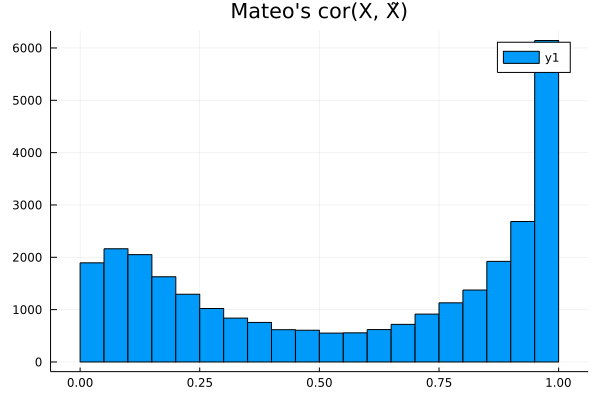

In [7]:
# correlation between X and X̃
X_ko = readdlm("../fastphase/mateo_knockoff.txt")
n, p = size(X)
r2, snp1 = sizehint!(Float64[], p), zeros(n)
for i in 1:p
    copyto!(snp1, @view(X[:, i]), center=true, scale=true)
    push!(r2, abs(cor(snp1, @view(X_ko[:, i]))))
end
histogram(r2, title="Mateo's cor(X, X̃)")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


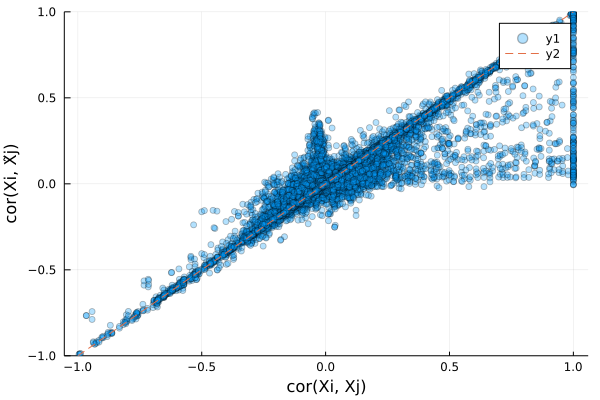

In [8]:
# compare cor(X[i], X[j]) and cor(X[i], X̃[j])
n, p = size(X)
r1, r2, snp1, snp2 = Float64[], Float64[], zeros(n), zeros(n)
@showprogress for i in 1:200, j in 1:200
    copyto!(snp1, @view(X[:, i]))
    copyto!(snp2, @view(X[:, j]))
    push!(r1, cor(snp1, snp2))
    push!(r2, cor(snp1, @view(X_ko[:, j])))
end
mateo_plt = scatter(r1, r2, alpha=0.3, ylim=(-1, 1), xlabel = "cor(Xi, Xj)", ylabel="cor(Xi, X̃j)")
Plots.abline!(1, 0, line=:dash)

## Compare 2 plots

They are very similar but slightly different. 

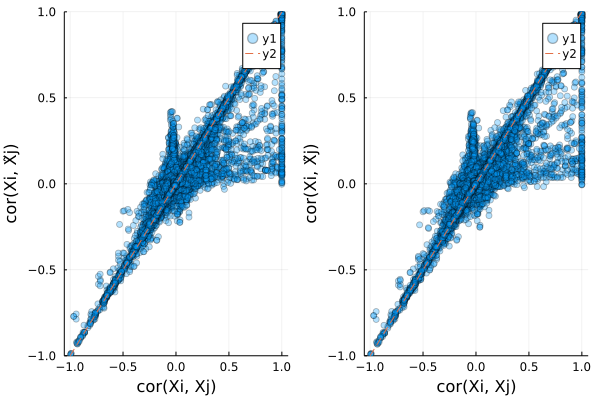

In [9]:
plot(julia_plt, mateo_plt)

# Generate Markov chain knockoffs

In [2]:
function sample_DMC(q, Q; n=1)
    p = size(Q, 3)
    d = Categorical(q)
    X = zeros(Int, n, p)
    for i in 1:n
        X[i, 1] = rand(d)
        for j in 2:p
            d.p .= @view(Q[X[i, j-1], :, j])
            X[i, j] = rand(d)
        end
    end
    return X
end

sample_DMC (generic function with 1 method)

Generate Markov chain knockoffs 

In [3]:
p = 100 # Number of states in markov chain
K = 5   # Number of possible states for each variable
q = 1/K .* ones(K) # Marginal distribution for the first variable
samples = 100000 # number of samples in this example

# form random transition matrices
Q = rand(K, K, p)
for j in 1:p
    Qj = @view(Q[:, :, j])
    Qj ./= sum(Qj, dims=2)
end
fill!(@view(Q[:, :, 1]), NaN)

# sample a bunch of markov chains
X = sample_DMC(q, Q, n=samples)

# sample knockoff of the markov chains
X̃ = zeros(Int, samples, p)
N = zeros(p, K)
d = Categorical([1 / K for _ in 1:K])
for i in 1:samples
    markov_knockoffs!(@view(X̃[i, :]), @view(X[i, :]), N, d, Q, q) 
end

In [4]:
# also generate Mateo's knockoffs
Qmateo = zeros(p-1, K, K) # need to get rid of Q1
for j in 1:p-1
    Qmateo[j, :, :] .= Q[:, :, j+1]
end
Xmateo = X .- 1# states begin with 0
@rput Qmateo Xmateo q;

R"""
library("SNPknock")

# Generate knockoffs
Xko_mateo = knockoffDMC(Xmateo, q, Qmateo)
"""

@rget Xko_mateo
Xko_mateo .+= 1;

### Julia Knockoffs

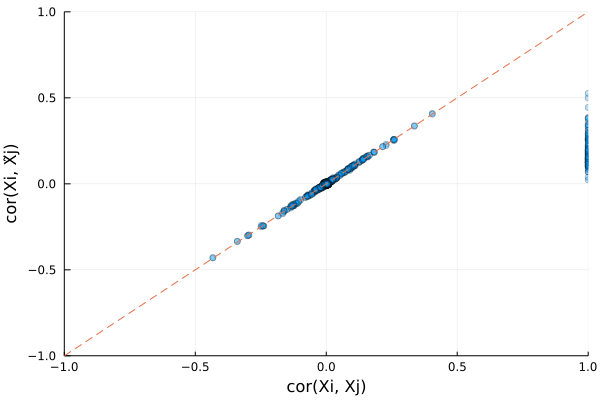

In [5]:
# compare cor(X[i], X[j]) and cor(X[i], X̃[j])
n, p = size(X)
r1, r2, snp1, snp2 = Float64[], Float64[], zeros(n), zeros(n)
for i in 1:p, j in 1:p
    push!(r1, cor(@view(X[:, i]), @view(X[:, j])))
    push!(r2, cor(@view(X[:, i]), @view(X̃[:, j])))
end
scatter(r1, r2, alpha=0.3, xlim=(-1, 1), ylim=(-1, 1), 
    xlabel = "cor(Xi, Xj)", ylabel="cor(Xi, X̃j)")
Plots.abline!(1, 0, line=:dash, legend=false)

### Mateo's Knockoffs

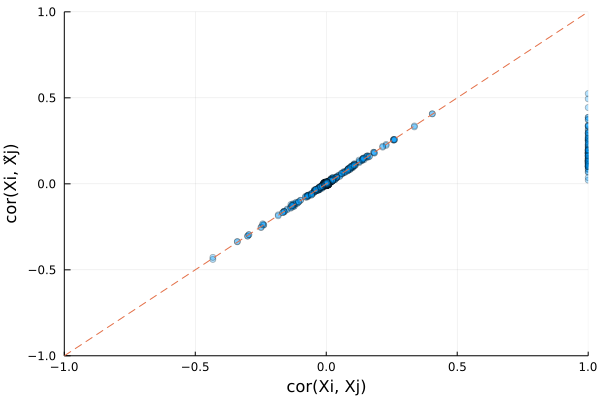

In [6]:
# compare cor(X[i], X[j]) and cor(X[i], X̃[j])
n, p = size(X)
r1, r2, snp1, snp2 = Float64[], Float64[], zeros(n), zeros(n)
for i in 1:p, j in 1:p
    push!(r1, cor(@view(X[:, i]), @view(X[:, j])))
    push!(r2, cor(@view(X[:, i]), @view(Xko_mateo[:, j])))
end
scatter(r1, r2, alpha=0.3, xlim=(-1, 1), ylim=(-1, 1), 
    xlabel = "cor(Xi, Xj)", ylabel="cor(Xi, X̃j)")
Plots.abline!(1, 0, line=:dash, legend=false)

### Check column means match

In [7]:
# Julia version
[mean(X, dims=1); mean(X̃, dims=1)] 

2×100 Matrix{Float64}:
 3.04913  2.75799  2.47469  3.33402  …  2.95588  2.74221  3.30306  3.05239
 2.98791  2.75522  2.48771  3.3336      2.95684  2.74495  3.31022  3.0535

In [8]:
# Mateo's version
[mean(X, dims=1); mean(Xko_mateo, dims=1)] 

2×100 Matrix{Float64}:
 3.04913  2.75799  2.47469  3.33402  …  2.95588  2.74221  3.30306  3.05239
 2.98639  2.76123  2.48158  3.33838     2.95429  2.74688  3.30305  3.05047

### Check internal column correlations match

In [9]:
# Julia version
r2 = Float64[]
r2_julia_ko = Float64[]
r2_mateo_ko = Float64[]
for i in 1:p-1
    push!(r2, cor(@view(X[:, i]), @view(X[:, i+1])))
    push!(r2_julia_ko, cor(@view(X̃[:, i]), @view(X̃[:, i+1])))
    push!(r2_mateo_ko, cor(@view(Xko_mateo[:, i]), @view(Xko_mateo[:, i+1])))
end

[r2 r2_mateo_ko r2_julia_ko]

99×3 Matrix{Float64}:
 -0.13516      -0.120459    -0.127722
  0.40483       0.406826     0.408521
 -0.0694676    -0.064387    -0.0675639
 -0.0294645    -0.0339926   -0.0325399
  0.0182949     0.0133954    0.0132935
  0.136201      0.13789      0.133288
  0.0924267     0.0876075    0.0879694
 -0.0708985    -0.0701909   -0.0628362
  0.101273      0.0992326    0.0985014
  0.00650713    0.00127189   0.00603624
  0.000970288   0.00266501  -0.00618317
  0.126404      0.121151     0.128097
 -0.12213      -0.128498    -0.129195
  ⋮                         
 -0.028686     -0.0204309   -0.0230455
  0.183669      0.179816     0.176785
 -0.160592     -0.161123    -0.161901
 -0.0984098    -0.0941277   -0.0934317
  0.0935808     0.0905898    0.0982488
 -0.131458     -0.122671    -0.120921
  0.164537      0.164704     0.167034
 -0.0396847    -0.0326108   -0.0366593
 -0.105358     -0.10304     -0.102061
  0.106344      0.105822     0.105737
 -0.166297     -0.168806    -0.167779
 -0.295393     -0.30006

### Check that cross column correlations match

In [10]:
# Julia version
r2 = Float64[]
r2_julia_ko = Float64[]
r2_mateo_ko = Float64[]
for i in 1:p-1
    push!(r2, cor(@view(X[:, i]), @view(X[:, i+1])))
    push!(r2_julia_ko, cor(@view(X[:, i]), @view(X̃[:, i+1])))
    push!(r2_mateo_ko, cor(@view(X[:, i]), @view(Xko_mateo[:, i+1])))
end

[r2 r2_mateo_ko r2_julia_ko]

99×3 Matrix{Float64}:
 -0.13516      -0.133328     -0.132677
  0.40483       0.407385      0.409242
 -0.0694676    -0.0730782    -0.0674507
 -0.0294645    -0.0374015    -0.0305958
  0.0182949     0.0174378     0.0147237
  0.136201      0.135828      0.133904
  0.0924267     0.0886535     0.0871855
 -0.0708985    -0.0677134    -0.07133
  0.101273      0.0934955     0.0996072
  0.00650713    0.000848297   0.00601582
  0.000970288  -0.00243179    0.000136779
  0.126404      0.123192      0.12551
 -0.12213      -0.129043     -0.126088
  ⋮                          
 -0.028686     -0.0251183    -0.0229991
  0.183669      0.177934      0.182762
 -0.160592     -0.161226     -0.16088
 -0.0984098    -0.0961979    -0.089816
  0.0935808     0.100591      0.0908137
 -0.131458     -0.123721     -0.123212
  0.164537      0.158091      0.165013
 -0.0396847    -0.0322368    -0.0364549
 -0.105358     -0.104625     -0.106459
  0.106344      0.109774      0.103243
 -0.166297     -0.167501     -0.169194
 -

# Compare imports of $r, \theta, \alpha$

In [21]:
r, θ, α = process_fastphase_output("./1k/tmp1")

([1.0, 0.0002300871, 8.09653e-5, 4.43899e-5, 0.0005491704, 0.0011267751, 0.0012999466, 0.0014388165, 0.0020597433, 0.0010472368  …  0.0012638135, 0.0014580701, 6.35936e-5, 0.0002415371, 0.0007763753, 0.0002353962, 0.0001023672, 7.9107e-6, 1.35113e-5, 1.45839e-5], [0.0010000000000000009 0.0010000000000000009 … 0.0010000000000000009 0.0010000000000000009; 0.001 0.001 … 0.980165 0.001127; … ; 0.001 0.003229 … 0.001 0.999; 0.001 0.003644 … 0.001 0.025529], [0.113475 0.097686 … 0.096388 0.092518; 0.113475 0.097686 … 0.096388 0.092518; … ; 0.113475 0.097686 … 0.096388 0.092518; 0.113475 0.097686 … 0.096388 0.092518])

In [12]:
# Mateo's version
p = length(r)
@rput p
R"""
library("SNPknock")

# fastPHASE output files
r_file = "/Users/biona001/.julia/dev/Knockoffs/fastphase/1k/tmp1_rhat.txt"
alpha_file = "/Users/biona001/.julia/dev/Knockoffs/fastphase/1k/tmp1_alphahat.txt"
theta_file = "/Users/biona001/.julia/dev/Knockoffs/fastphase/1k/tmp1_thetahat.txt"
char_file = "/Users/biona001/.julia/dev/Knockoffs/fastphase/1k/tmp1_origchars"

# load HMM
hmm = loadHMM(r_file, alpha_file, theta_file, char_file)
hmm$r = hmm$r[1:p]
hmm$alpha = hmm$alpha[1:p,]
hmm$theta = hmm$theta[1:p,]


r_mateo = print(hmm$r)
theta_mateo = hmm$theta[1:p,]
alpha_mateo = hmm$alpha[1:p,];
"""

@rget r_mateo theta_mateo alpha_mateo;

    [1] 1.0000000000 0.0002300871 0.0000809653 0.0000443899 0.0005491704
    [6] 0.0011267751 0.0012999466 0.0014388165 0.0020597433 0.0010472368
   [11] 0.0068822151 0.0105602321 0.0356444590 0.0214015198 0.0006687199
   [16] 0.0003300315 0.0048941741 0.0024067156 0.0019455734 0.0024634480
   [21] 0.0000032315 0.0000015851 0.0000106083 0.0000087687 0.0000000289
   [26] 0.0000000267 0.0000000699 0.0000010223 0.0000027981 0.0000043573
   [31] 0.0071858233 0.0031310019 0.0075498403 0.0290482112 0.1178881871
   [36] 0.1604215538 0.3419745752 0.0674708110 0.0182973047 0.0021329269
   [41] 0.0008485912 0.0009108455 0.0072199745 0.0035614414 0.0054750812
   [46] 0.0063183468 0.0060421937 0.0024132926 0.0626287119 0.0606787811
   [51] 0.0032903809 0.0017159513 0.0003834969 0.0004761448 0.0051686858
   [56] 0.0057085172 0.0088982126 0.0030675802 0.0016106933 0.0130150916
   [61] 0.0081208033 0.0340810647 0.0302279879 0.0164627075 0.0007919745
   [66] 0.0034853232 0.0067987390 0.0096308739 0.01

In [23]:
[vec(r_mateo) vec(α)]

294810×2 Matrix{Float64}:
 0.113475  0.113475
 0.113475  0.113475
 0.113475  0.113475
 0.113475  0.113475
 0.113475  0.113475
 0.113475  0.113475
 0.113475  0.113475
 0.113475  0.113475
 0.113475  0.113475
 0.113475  0.113475
 0.113475  0.113475
 0.113475  0.113475
 0.113475  0.113475
 ⋮         
 0.092518  0.092518
 0.092518  0.092518
 0.092518  0.092518
 0.092518  0.092518
 0.092518  0.092518
 0.092518  0.092518
 0.092518  0.092518
 0.092518  0.092518
 0.092518  0.092518
 0.092518  0.092518
 0.092518  0.092518
 0.092518  0.092518